# **Model Forecast - Comparison and Improvement**

In [47]:
#Necessary Pip Installs 
!pip install pmdarima
!pip install prophet

In [48]:
#Imports
import pandas as pd
import numpy as np
import math
%matplotlib inline

# Load specific forecasting tools
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
import statsmodels.api as sm
from matplotlib import pyplot
#ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.statespace.tools import diff
from pmdarima import auto_arima # for determining ARIMA orders  
from statsmodels.tsa.arima.model import ARIMA
#Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly
#Metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller

In [90]:
#Import the Dataset
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/input.xlsx')
df.rename(columns={'SalesVolume':'Values'},inplace=True)
df = df.dropna()

In [93]:
df.tail()

,Date,Values
315,2021-04-01,66565
316,2021-05-01,56135
317,2021-06-01,103085
318,2021-07-01,21935
319,2021-08-01,26661


In [107]:
auto_arima_summary,arima_df = arima_check(df)
print(auto_arima_summary)

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.474777
p-value                   0.121733
# lags used              13.000000
# observations          306.000000
critical value (1%)      -3.451902
critical value (5%)      -2.871032
critical value (10%)     -2.571827
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augmented Dickey-Fuller Test: 
ADF test statistic       -5.328886
p-value                   0.000005
# lags used              17.000000
# observations          301.000000
critical value (1%)      -3.452263
critical value (5%)      -2.871191
critical value (10%)     -2.571912
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Requires differencing of order:  1
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  320
Model:               SAR

In [108]:
#Choose model
order = (4,1,2)
arima_pred_df = arima_train(arima_df,order,'SARIMAX')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [131]:
#Metrics
metrics_df = pd.DataFrame(columns=['TYPE','MAPE','MSE','RMSE','MAE'])
metrics_df = metrics(metrics_df,arima_pred_df,'ARIMA')

In [134]:
metrics_df

,TYPE,MAPE,MSE,RMSE,MAE
0,ARIMA,0.524636,7.200069e+08,26832.943527,22166.488277


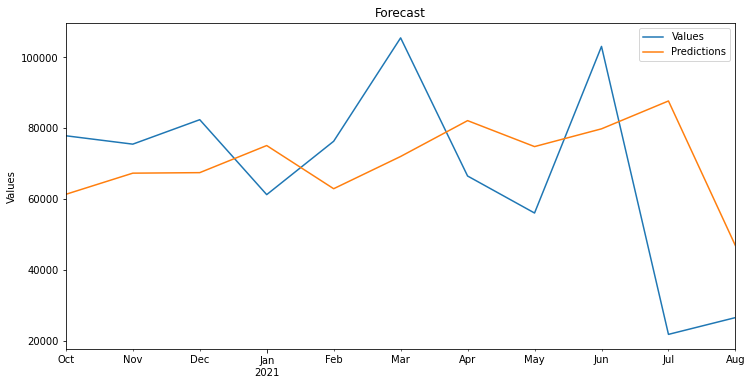

In [135]:
arima_plot(arima_pred_df)

In [83]:
def arima_check(arima_df):
  arima_df = arima_preprocess(arima_df)
  diff_order = stationarity_check(arima_df)
  if diff_order > 0:
    print('Requires differencing of order: ',diff_order )
  auto_arima_summary = auto_arima(arima_df['Values'], seasonal=False).summary()
  return auto_arima_summary,arima_df

In [106]:
def stationarity_check(st_check_df):
  order = 0
  input_df = st_check_df.copy()
  while True:
    check_stationarity = adf_test(input_df['Values'])
    if not check_stationarity:
      input_df['Values'] = diff(input_df['Values'],k_diff=1)
      input_df = input_df.iloc[1:,:]
      order +=1
      continue
    else:
      break
  return order

In [85]:
#Preprocessing before feeding into the ARIMA models
def arima_preprocess(input_df):
  """
  Pass in the input df returns a dataframe after processing the date field
  """
  input_df['Date'] = pd.DatetimeIndex(input_df['Date'])
  input_df = input_df.groupby('Date').sum()
  #Settting a Monthly frequency and also to the first day of the month
  input_df = input_df.asfreq('MS')
  return input_df

In [86]:
#Stationarity Check
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
        return True
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        return False

In [132]:
#Metrics Evaluation
def metrics(metrics_df,input_df,model_type):
  metrics_df = metrics_df.append({'TYPE':model_type,
                                  'MAPE':mean_absolute_percentage_error(input_df['Values'], input_df['Predictions']),
                                  'MSE':mean_squared_error(input_df['Values'], input_df['Predictions']),
                                  'RMSE':rmse(input_df['Values'], input_df['Predictions']),
                                  'MAE':mean_absolute_error(input_df['Values'], input_df['Predictions'])
                                  }
                                 ,ignore_index=True)
  return metrics_df

In [76]:
def arima_train(arima_df,order_tpl,model_type):
  # Setting the last 7 months for testing
  model = None
  index = len(arima_df) - 11
  train = arima_df.iloc[:index]
  test = arima_df.iloc[index:]
  if model_type == 'SARIMAX':
    model=sm.tsa.statespace.SARIMAX(arima_df['Values'],order=order_tpl)
  elif model_type == 'ARIMA':
    model=sm.tsa.statespace.ARIMA(arima_df['Values'],order=order_tpl)
  results=model.fit()
  start=len(train)
  end=len(train)+len(test)-1
  predictions_SARIMAX = results.predict(start=start, end=end).rename('Predictions')
  test['Predictions'] = predictions_SARIMAX
  return test

In [77]:
def arima_plot(plot_df):
  title = 'Forecast'
  ylabel='Values'

  ax = plot_df['Values'].plot(legend=True,figsize=(12,6),title=title)
  plot_df['Predictions'].plot(legend=True)
  ax.autoscale(axis='x',tight=True)
  ax.set(xlabel=xlabel, ylabel=ylabel);

In [182]:
def prophet_base_model(input_df):
  prophet_forecast = prophet_model(input_df)
  index = len(prophet_forecast) - 11
  prophet_forecast = prophet_forecast[index:].rename(columns={'ds':'Date','yhat':'Predictions'})
  prophet_pred_df = prophet_forecast[['Date','Predictions']]
  prophet_metrics_df = df[index:]
  prophet_metrics_df = prophet_metrics_df.merge(prophet_pred_df, on='Date', how='left')
  metrics_df = metrics(metrics_df,prophet_metrics_df,'Prophet')
  return prophet_metrics_df,metrics_df

In [144]:
def prophet_model(input_df):
  index = len(input_df) - 11
  train_df = input_df[:index].rename(columns={'Date':'ds', 'Values':'y'})
  default_params = {  
    'changepoint_prior_scale': 0.05,
    'changepoint_range' : 0.8,
    'seasonality_prior_scale': 10.0,
  }
  model , forecast = model_train_predict(train_df,default_params)
  return forecast

In [158]:
#Train and fit the model
def model_train_predict(input_df,params):
  m = Prophet( seasonality_mode='additive', 
            yearly_seasonality= True,
            daily_seasonality = False,
            weekly_seasonality = False,
            **params)
  m.fit(input_df)
  # Forcasting into the future
  future = m.make_future_dataframe(periods=11,freq='MS')
  forecast = m.predict(future)
  return m, forecast